In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from time import clock
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import defaultdict

In [13]:
from sklearn.base import TransformerMixin,BaseEstimator
# http://datascience.stackexchange.com/questions/6683/feature-selection-using-feature-importances-in-random-forests-with-scikit-learn          
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

**Load Spam**

In [14]:
spam_df = pd.read_csv('spambase.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
spam_x = StandardScaler().fit_transform(spam_x)
spam_x.shape

(4601, 57)

**Load digits**

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
digits_x = StandardScaler().fit_transform(digits.data)
digits_y = digits.target
digits_x.shape

(1797, 64)

In [20]:
rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5)
fs_spam = rfc.fit(spam_x,spam_y).feature_importances_ 
fs_digits = rfc.fit(digits_x,digits_y).feature_importances_ 
spam_tmp = pd.Series(np.sort(fs_spam)[::-1])
digits_tmp = pd.Series(np.sort(fs_digits)[::-1])

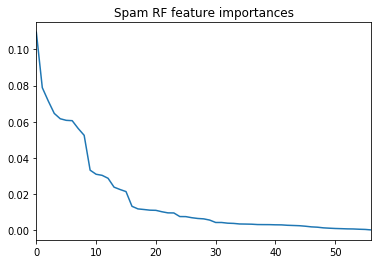

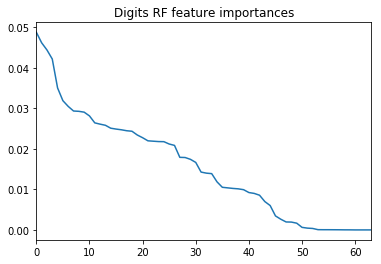

In [21]:
spam_tmp.plot(title="Spam RF feature importances")
plt.show()
digits_tmp.plot(title="Digits RF feature importances")

In [27]:
from helpers import cluster_acc
rfc = RandomForestClassifier(class_weight='balanced',random_state=5)
impspam = ImportanceSelect(rfc, n=30)
spam_x_red = impspam.fit_transform(spam_x, spam_y)
impdigits = ImportanceSelect(rfc, n=50)
digits_x_red = impdigits.fit_transform(digits_x, digits_y)
km = KMeans(random_state=5)
gmm = GaussianMixture(random_state=5)
clusters =  [2,5,10,15,20,25,30,35,40,50,70,80,90,100,115,130]
accSpam = {}
acc = defaultdict(lambda: defaultdict(dict))
SSE = defaultdict(dict)
ll = defaultdict(dict)
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(digits_x_red)
    gmm.fit(digits_x_red)
    acc[k]['digits']['kmeans'] = cluster_acc(digits_y, km.predict(digits_x_red))
    acc[k]['digits']['gmm'] = cluster_acc(digits_y, gmm.predict(digits_x_red))
    SSE[k]['digits'] = km.score(digits_x_red)
    ll[k]['digits'] = gmm.score(digits_x_red)
    km.fit(spam_x_red)
    gmm.fit(spam_x_red)
    acc[k]['spam']['kmeans'] = cluster_acc(spam_y, km.predict(spam_x_red))
    acc[k]['spam']['gmm'] = cluster_acc(spam_y, gmm.predict(spam_x_red))
    SSE[k]['spam'] = km.score(spam_x_red)
    ll[k]['spam'] = gmm.score(spam_x_red)    

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


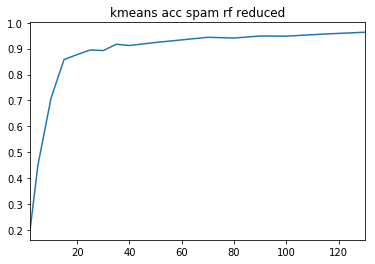

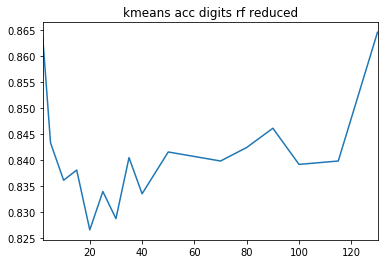

In [32]:
kmeansAccSpam = defaultdict(dict)
kmeansAccDigits = defaultdict(dict)
for k in acc:
    kmeansAccSpam[k] = acc[k]['digits']['kmeans']
    kmeansAccDigits[k] = acc[k]['spam']['kmeans']

pd.DataFrame.from_dict(kmeansAccSpam, orient='index', columns=['acc']).plot(title='kmeans acc spam rf reduced', legend=False)
pd.DataFrame.from_dict(kmeansAccDigits, orient='index', columns=['acc']).plot(title='kmeans acc digits rf reduced', legend=False)

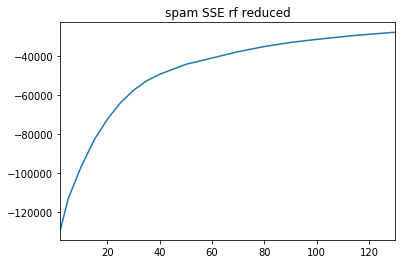

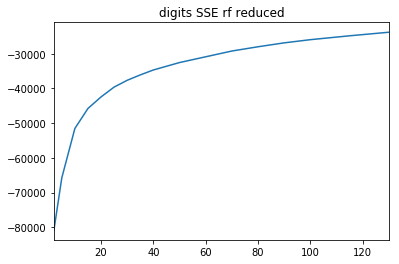

In [33]:
pd.DataFrame.from_dict(SSE, orient='index')['spam'].plot(title='spam SSE rf reduced')
plt.show()
pd.DataFrame.from_dict(SSE, orient='index')['digits'].plot(title='digits SSE rf reduced')

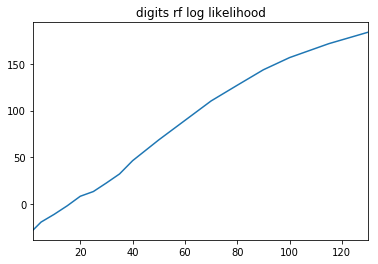

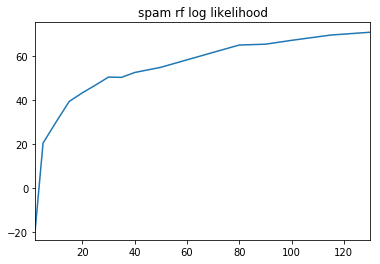

In [34]:
pd.DataFrame.from_dict(ll, orient='index')['digits'].plot(title='digits rf log likelihood')
plt.show()
pd.DataFrame.from_dict(ll, orient='index')['spam'].plot(title='spam rf log likelihood')

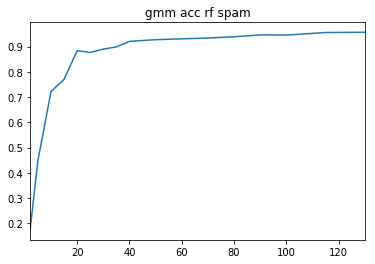

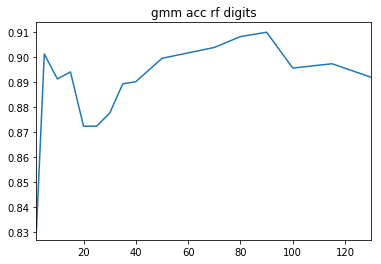

In [35]:
gmmAccSpam = defaultdict(dict)
gmmAccDigits = defaultdict(dict)
for k in acc:
    gmmAccSpam[k] = acc[k]['digits']['gmm']
    gmmAccDigits[k] = acc[k]['spam']['gmm']

pd.DataFrame.from_dict(gmmAccSpam, orient='index', columns=['acc']).plot(title='gmm acc rf spam', legend=False)
pd.DataFrame.from_dict(gmmAccDigits, orient='index', columns=['acc']).plot(title='gmm acc rf digits', legend=False)

In [23]:
dims = [2,5,10,15,20,25,30,35,40,45,50,55]
dims_times = {}
dims_acc = {}
rfc = RandomForestClassifier(class_weight='balanced',random_state=5)
for d in range(1, spam_x.shape[1] + 1):
    filterer = ImportanceSelect(rfc, d)
    spam_red = filterer.fit_transform(spam_x, spam_y)
    mlp = MLPClassifier(activation='relu',max_iter=2000,early_stopping=True,random_state=5, hidden_layer_sizes=(spam_red.shape[1], 57, 57))
    st = clock()
    mlp.fit(spam_red, spam_y)
    dims_times[d] = clock() - st
    dims_acc[d] = mlp.score(spam_red, spam_y)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/usr/

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.proces

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.proces

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.proces

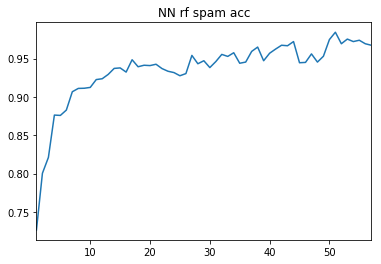

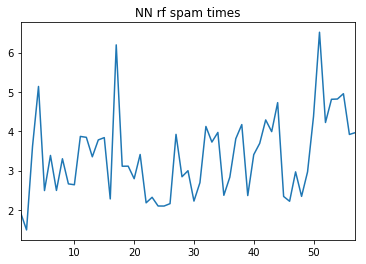

In [16]:
pd.DataFrame.from_dict(dims_acc, orient='index').plot(title='NN rf spam acc', legend=False)
pd.DataFrame.from_dict(dims_times, orient='index').plot(title='NN rf spam times', legend=False)